In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statrange_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []
}

indaccs = {}

In [8]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 14].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 14].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrange_dic['Run Time'].append(elapsed)
statrange_dic['Accuracy'].append(np.mean(acc_score))
statrange_dic['Standard Error'].append(np.std(acc_score))
statrange_dic['Sensitivity'].append(sensitivity)
statrange_dic['Specificity'].append(specificity)
statrange_dic['Precision'].append(precision)
statrange_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.1909070289999999 seconds ---

Accuracy of each fold: 
 [0.7664458480973656, 0.7568567026194145, 0.7631741140215716, 0.773035439137134, 0.7750385208012327]
Avg accuracy: 0.7669101249353437
Std of accuracy : 
0.0066156620865304985

[[15742  3684]
 [ 3880  9145]]

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     19426
           1       0.71      0.70      0.71     13025

    accuracy                           0.77     32451
   macro avg       0.76      0.76      0.76     32451
weighted avg       0.77      0.77      0.77     32451

0.8103572531658602
0.7021113243761996
0.8022627662827438
0.8062896947346856


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 14].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 14].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrange_dic['Run Time'].append(elapsed)
statrange_dic['Accuracy'].append(np.mean(acc_score))
statrange_dic['Standard Error'].append(np.std(acc_score))
statrange_dic['Sensitivity'].append(sensitivity)
statrange_dic['Specificity'].append(specificity)
statrange_dic['Precision'].append(precision)
statrange_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.07260712999999974 seconds ---

Accuracy of each fold: 
 [0.7672161454321368, 0.7599383667180277, 0.7631741140215716, 0.7742681047765794, 0.7773497688751926]
Avg accuracy: 0.7683892999647015
Std of accuracy : 
0.00655504504683939

[[15705  3721]
 [ 3795  9230]]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     19426
           1       0.71      0.71      0.71     13025

    accuracy                           0.77     32451
   macro avg       0.76      0.76      0.76     32451
weighted avg       0.77      0.77      0.77     32451

0.8084525893132914
0.708637236084453
0.8053846153846154
0.8069156861737655


In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 14].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 14].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrange_dic['Run Time'].append(elapsed)
statrange_dic['Accuracy'].append(np.mean(acc_score))
statrange_dic['Standard Error'].append(np.std(acc_score))
statrange_dic['Sensitivity'].append(sensitivity)
statrange_dic['Specificity'].append(specificity)
statrange_dic['Precision'].append(precision)
statrange_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.050234740999998806 seconds ---

Accuracy of each fold: 
 [0.7718379294407641, 0.7665639445300462, 0.7711864406779662, 0.7822804314329738, 0.7850539291217258]
Avg accuracy: 0.7753845350406953
Std of accuracy : 
0.007057702083025343

[[15569  3857]
 [ 3432  9593]]

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     19426
           1       0.71      0.74      0.72     13025

    accuracy                           0.78     32451
   macro avg       0.77      0.77      0.77     32451
weighted avg       0.78      0.78      0.78     32451

0.8014516627200658
0.7365067178502879
0.8193779274775012
0.8103156634657923


In [11]:
#KNN-CV
KNN_result = []
X=subject_df["Range"].values.reshape(-1,1)
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.73609613 0.75624037 0.73266564 0.75362096 0.74206471]
Avg accuracy: 0.7441375625228626

K = 2
Accuracy of each fold: 
 [0.68618087 0.72172573 0.70354391 0.70400616 0.70878274]
Avg accuracy: 0.7048478834864156

K = 3
Accuracy of each fold: 
 [0.74071792 0.76671803 0.76178737 0.77395994 0.77118644]
Avg accuracy: 0.7628739378145728

K = 4
Accuracy of each fold: 
 [0.7282391  0.74391371 0.73636364 0.74576271 0.7394453 ]
Avg accuracy: 0.738744892477649

K = 5
Accuracy of each fold: 
 [0.76213218 0.76656394 0.77904468 0.78412943 0.77873652]
Avg accuracy: 0.7741213518587666

K = 6
Accuracy of each fold: 
 [0.75042366 0.74468413 0.75238829 0.76286595 0.76163328]
Avg accuracy: 0.7543990624448833

K = 7
Accuracy of each fold: 
 [0.76505931 0.77211094 0.77827427 0.78705701 0.78228043]
Avg accuracy: 0.7769563926251803

K = 8
Accuracy of each fold: 
 [0.76290248 0.75238829 0.76302003 0.7642527  0.77781202]
Avg accuracy: 0.764075103159311

K = 9
Accuracy of each fol

In [12]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 14].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 14].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statrange_dic['Run Time'].append(elapsed)
statrange_dic['Accuracy'].append(np.mean(acc_score))
statrange_dic['Standard Error'].append(np.std(acc_score))
statrange_dic['Sensitivity'].append(sensitivity)
statrange_dic['Specificity'].append(specificity)
statrange_dic['Precision'].append(precision)
statrange_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 2.145772364999999 seconds ---

Accuracy of each fold: 
 [0.7650593128947774, 0.7721109399075501, 0.7782742681047766, 0.7870570107858244, 0.7822804314329738]
Avg accuracy: 0.7769563926251803
Std of accuracy : 
0.007708742963468157

[[14546  4880]
 [ 2358 10667]]

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     19426
           1       0.69      0.82      0.75     13025

    accuracy                           0.78     32451
   macro avg       0.77      0.78      0.77     32451
weighted avg       0.79      0.78      0.78     32451

0.7487902810666117
0.8189635316698657
0.8605063890203503
0.8007707129094412


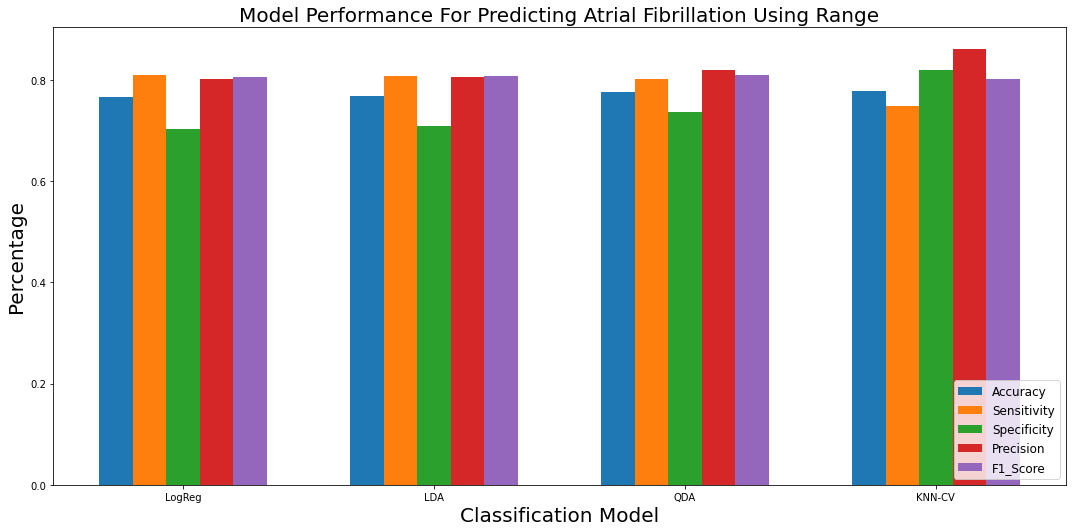

In [13]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statrange_dic["Accuracy"]
sensitivities = statrange_dic["Sensitivity"]
specificities = statrange_dic["Specificity"]
precisions = statrange_dic["Precision"]
f1_scores = statrange_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Range', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('RangeModel.png')

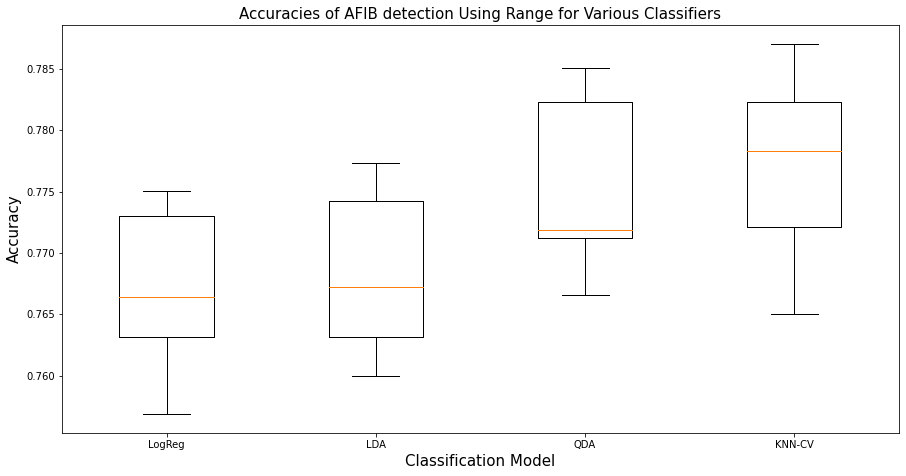

In [14]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using Range for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('RangeBox.png')

In [15]:
rangedf = pd.DataFrame(
    data = np.transpose(np.array([
                                statrange_dic["Accuracy"],
                                statrange_dic["Standard Error"],
                                statrange_dic["Sensitivity"],
                                statrange_dic["Specificity"],
                                statrange_dic["Precision"],
                                statrange_dic["F1_Score"],
                                statrange_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

rangedf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.766910,0.006616,0.810357,0.702111,0.802263,0.806290,0.190907
LDA,0.768389,0.006555,0.808453,0.708637,0.805385,0.806916,0.072607
QDA,0.775385,0.007058,0.801452,0.736507,0.819378,0.810316,0.050235
KNN-CV,0.776956,0.007709,0.748790,0.818964,0.860506,0.800771,2.145772
